##  I - Prepare Data

### 1. Description of the dataset

<p>Cookie Cats, a popular mobile puzzle game by Tactile Entertainment, challenges players to connect colored tiles to clear levels and features singing cats.</p>

<p>In this project, the impact of moving the first gate from level 30 to level 40 is analyzed through an A/B test, focusing on how this change affects player retention.</p>

<p>Where should the gates be positioned? Initially, the first gate was set at level 30, but in this notebook, we'll analyze an A/B test where the first gate in Cookie Cats was shifted from level 30 to level 40. Specifically, we'll examine the effect this change had on player retention. However, before diving into the analysis, it's important to first understand the data. Let's load the data and explore it!</p>

In [1]:
# Importing libraries
import pandas as pd

# Reading in the data
df = pd.read_csv('./cookie_cats_data.csv')

# View data
df.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


### 2. The AB-test data

Data from 90,189 players who installed the game during the A/B test period includes the following variables:
<ul>
<li> userid: A unique identifier for each player.</li>
<li>version: Indicates whether the player was placed in the control group (gate_30, with a gate at level 30) or in the test group (gate_40, with the gate moved to level 40).</li>
<li> sum_gamerounds: The total number of game rounds played by the player within the first 14 days after installation.</li>
<li> retention_1: Indicates whether the player returned to play 1 day after installing the game.</li>
<li> retention_7: Indicates whether the player returned to play 7 days after installing the game.</li>
</ul>

When a player installed the game, they were randomly assigned to either gate_30 or gate_40. As a preliminary check, let's ensure that both A/B groups have approximately the same number of players.

In [2]:
# Counting players in each a/b group
df.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


### 3 - Distribution of Game Rounds
<p>It appears that both groups have a similar number of players</p>
<p>While the main focus of this analysis is to explore how gate placement influences player retention, let's have a bit of fun: we'll plot the distribution of the number of game rounds played by players during their first week in the game..</p>

Text(0, 0.5, 'Player Counts')

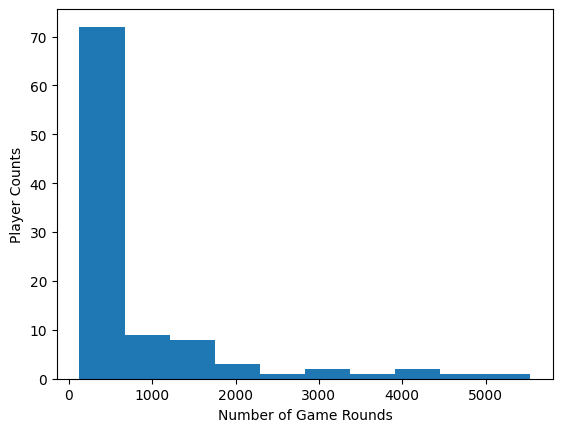

In [3]:
# Ensure plots are displayed within the notebook
%matplotlib inline

# Count the number of players for each number of game rounds
plot_df = df.groupby('sum_gamerounds')['userid'].count()

# Plot the distribution of players who played between 0 and 100 game rounds
ax = plot_df.head(n=100).plot(x="sum_gamerounds", y="userid", kind = "hist")
ax.set_xlabel("Number of Game Rounds")
ax.set_ylabel("Player Counts")

## II - A/B Testing

### 1. Analyzing 1-Day Retention
<p>In the plot above, we observe that some players install the game but never actually play it (0 game rounds), others play only a few rounds in their first week, while some players become deeply engaged.</p>
<p>Our goal is to get players hooked and enjoying the game. A key metric used in the video game industry to measure how fun and engaging a game is, is 1-day retention: the percentage of players who return and play the game one day after installing it. The higher the 1-day retention rate, the easier it is to keep players engaged and grow a large player base.</p>
<p>To begin, let's take a look at the overall 1-day retention rate.</p>

In [4]:
# Calculate the percentage of users who returned the day after installation
df['retention_1'].mean()

0.4452095044850259

### 2. 1-Day Retention by A/B Group
<p>So, a little less than half of the players come back one day after installing the game. Now that we have a benchmark, let's look at how 1-day retention differs between the two AB-groups.</p>

In [5]:
# Calculate 1-day retention for each A/B group
df.groupby('version')['retention_1'].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

### 3. Confidence in the Difference
<p>Moving the gate to level 40 slightly decreased 1-day retention (44.2%) compared to level 30 (44.8%). While the difference is small, it could still have a big impact. But how confident can we be that level 40 will consistently perform worse?</p>
<p>To assess this, we'll use bootstrapping: repeatedly re-sampling the data and calculating 1-day retention for each sample. This will help us measure the uncertainty of the retention figures.</p>

Text(0.5, 1.0, 'Density of Day 1 Retention Probabilities for the Two Groups')

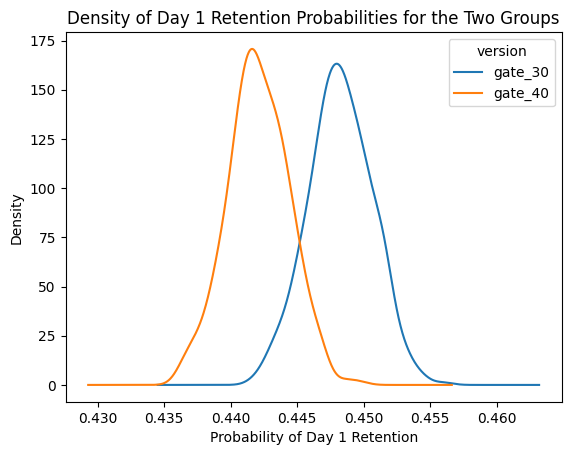

In [6]:
# Create a list with bootstrapped means for each A/B group
boot_1d = []
for _ in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)

# Convert the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)

# Plot the Kernel Density Estimate of the bootstrap distributions
plot_bs = boot_1d.plot(kind='kde')
plot_bs.set_xlabel("Probability of Day 1 Retention")
plot_bs.set_ylabel("Density")
plot_bs.set_title("Density of Day 1 Retention Probabilities for the Two Groups")

### 4. Examining the Difference in Detail
<p>The bootstrap distributions above show the uncertainty in 1-day retention for the two A/B groups. Visually, there seems to be a small difference. Let's focus on this difference in 1-day retention.</p>
<p>Note: The number of bootstrap replications is limited to 500 for speed. In practice, this number goes up to about 10,000 for better accuracy.</p>

Text(0.5, 1.0, 'Density of % Difference in Day 1 Retention Means')

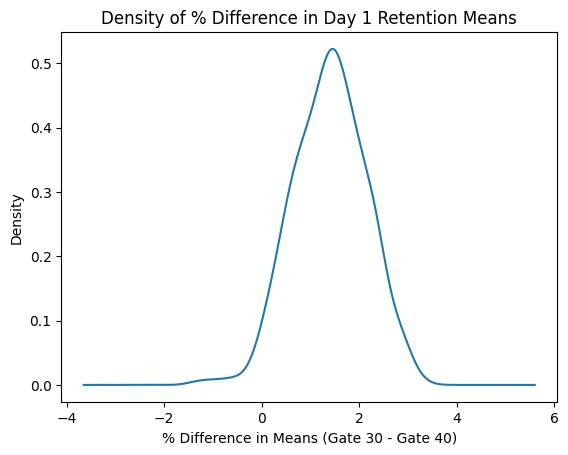

In [7]:
# Add a column with the % difference between the two A/B groups
boot_1d['diff'] = (boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100

# Plot the density of the % difference
ax = boot_1d['diff'].plot(kind='kde')
ax.set_xlabel("% Difference in Means (Gate 30 - Gate 40)")
ax.set_ylabel("Density")
ax.set_title("Density of % Difference in Day 1 Retention Means")

### 5. Probability of the Difference
<p>The chart indicates that the most probable percentage difference is between 1% and 2%, with most values above 0%, favoring a gate at level 30. Now, let's calculate the probability that the difference is indeed above 0%.</p>

In [8]:
# Calculate the probability that 1-day retention is higher with the gate at level 30
prob = (boot_1d['diff'] > 0).mean()

# Print the probability
print(prob)

0.978


### 6. 7-Day Retention by AB-Group
<p>The bootstrap analysis suggests that 1-day retention is likely better with the gate at level 30. However, since most players haven’t reached level 30 after just one day, the gate’s impact may be minimal at that point.</p>
<p>After a week, more players are expected to have reached level 40, making 7-day retention more relevant. This measures the percentage of players who returned to play a week after installing the game.</p>
<p>Let's calculate 7-day retention for both A/B groups.</p>

In [9]:
# Calculate 7-day retention for each A/B group
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

### 7. Rebootstrapping the Difference
<p>Similar to 1-day retention, 7-day retention is slightly lower (18.2%) with the gate at level 40 compared to level 30 (19.0%). This difference is more pronounced for 7-day retention, likely because more players have encountered the gate by this point. Additionally, overall 7-day retention is lower than 1-day retention, as fewer players return a week later.</p>
<p>We'll use bootstrap analysis to determine the certainty of the difference between the A/B groups.</p>

1.0


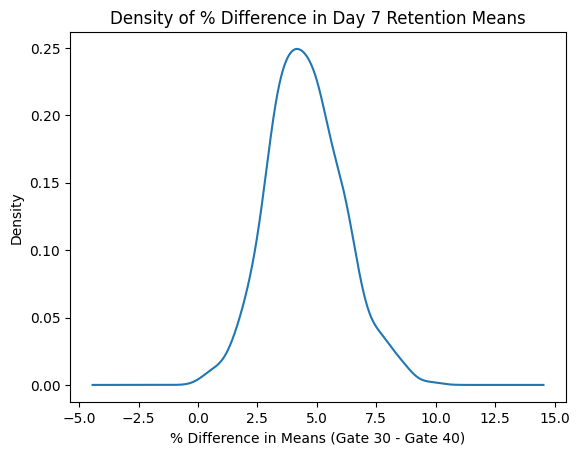

In [10]:
# Create a list with bootstrapped means for each A/B group
boot_7d = []
for _ in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)

# Convert the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Add a column with the % difference between the two A/B groups
boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100

# Plot the density of the % difference
ax = boot_7d['diff'].plot(kind='kde')
ax.set_xlabel("% Difference in Means (Gate 30 - Gate 40)")
ax.set_title('Density of % Difference in Day 7 Retention Means')

# Calculate the probability that 7-day retention is higher with the gate at level 30
prob = (boot_7d['diff'] > 0).mean()

# Print the probability
print(prob)

## III.  Conclusion
<p>The bootstrap analysis indicates strong evidence that 7-day retention is higher with the gate at level 30 compared to level 40. Thus, to maintain high retention rates, both 1-day and 7-day, it's better to keep the gate at level 30.</p>

<p>While other metrics, like game rounds or in-game purchases, are also important, retention is crucial. Without retaining players, their spending becomes irrelevant</p>

<p>One possible reason for higher retention at an earlier gate could be hedonic adaptation. This concept suggests that continuous engagement with a fun activity leads to reduced enjoyment over time. By placing the gate earlier, players take breaks and enjoy the game longer. If the gate is moved to level 40, fewer players reach it, and those who do may quit sooner due to boredom.</p>